In [2]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import time

# Data Preprocessing

In [3]:
df = pd.read_csv("songsDataset.csv")

# check for null entries
print(f"Null entries: \n{df.isnull().sum()}\n")

# unique users and songs
users = df["'userID'"].unique()
songs = df["'songID'"].sort_values().unique()

# number of users and songs
N_users = len(users)
N_songs = len(songs)
print(f"Number of Users: {N_users}")
print(f"Number of Songs: {N_songs}")

# map original song id to assigned song id
dct = {}
for i in range(len(songs)):
    dct[songs[i]] = i
df["'newSongID'"] = df["'songID'"].apply(lambda x: dct[x])

# train test split dataset
df_test = df.groupby("'songID'").sample(frac = 0.1, random_state = 69)
df_train = df.drop(df_test.index)

df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True).sort_values("'userID'")

Null entries: 
'userID'    0
'songID'    0
'rating'    0
dtype: int64

Number of Users: 200000
Number of Songs: 127771


In [4]:
@jax.jit
def loss(H, W, rating):
    error = jnp.dot(H, W) - rating
    return error**2

loss_grad = jax.jit(jax.grad(loss, argnums=(0,1)))

In [5]:
@jax.jit
def loss_with_bias(H, W, bu, bi, rating):
    pred = jnp.dot(H, W) + jnp.mean(np.array(df_train["'rating'"])) + bu + bi
    error = jnp.dot(H, W) - rating
    return error**2

loss_grad_with_bias = jax.jit(jax.grad(loss_with_bias, argnums=(0,1,2,3)))

In [6]:
@jax.jit
def mse(H_batch, W_batch, ratings_batch):
    predictions = jnp.sum(H_batch * W_batch, axis=1)
    errors = ratings_batch - predictions
    return jnp.mean(errors**2)

In [7]:
@jax.jit
def mse_with_bias(H_batch, W_batch, bu_batch, bi_batch, ratings_batch):
    predictions = jnp.sum(H_batch * W_batch, axis=1) + bu_batch + bi_batch + jnp.mean(np.array(df_train["'rating'"]))
    errors = ratings_batch - predictions
    return jnp.mean(errors**2)

# Model Building

In [8]:
latent_factors = 10

H_init = np.random.normal(0, 1, size=(N_users, latent_factors)) / np.sqrt(latent_factors)
W_init = np.random.normal(0, 1, size=(N_songs, latent_factors)) / np.sqrt(latent_factors)

## 1. Alternating Least Squares (ALS)

### 1.1. Whole dataset update

In [ ]:
n_iter = 5
lr = 0.05

H_als = H_init.copy()
W_als = W_init.copy()

training_losses1 = []
test_losses1 = []

for i in range(n_iter):
    start = time.time()
    
    for user in users:
        V = W_als[df_train[df_train["'userID'"] == user]["'newSongID'"]]
        R = jnp.array(df_train[df_train["'userID'"] == user]["'rating'"])
        
        A = jnp.dot(V.T, V) + 0.01 * jnp.eye(H_als.shape[1])
        b = jnp.dot(V.T, R)
        
        H_als[user] = jnp.linalg.solve(A, b)
    
    for song in songs:
        U = H_als[df_train[df_train["'songID'"] == song]["'userID'"]]
        R = jnp.array(df_train[df_train["'songID'"] == song]["'rating'"])
        
        A = jnp.dot(U.T, U) + 0.01 * jnp.eye(W_als.shape[1])
        b = jnp.dot(U.T, R)
        
        W_als[dct[song]] = jnp.linalg.solve(A, b)
    
    mse_train = mse(H_als[df_train["'userID'"]], W_als[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses1.append(mse_train)
    
    mse_test = mse(H_als[df_test["'userID'"]], W_als[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses1.append(mse_test)
    
    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

### 1.2. Sampling update

In [9]:
n_iter = 100
lr = 0.05

H_als_sampled = H_init.copy()
W_als_sampled = W_init.copy()

training_losses2 = []
test_losses2 = []

for i in range(n_iter):
    start = time.time()
    
    cur_users = users[np.random.permutation(len(users))][:5000]
    cur_songs = songs[np.random.permutation(len(songs))][:5000]
    
    for user in cur_users:
        V = W_als_sampled[df_train[df_train["'userID'"] == user]["'newSongID'"]]
        R = jnp.array(df_train[df_train["'userID'"] == user]["'rating'"])
        
        A = jnp.dot(V.T, V) + 0.01 * jnp.eye(H_als_sampled.shape[1])
        b = jnp.dot(V.T, R)
        
        H_als_sampled[user] = jnp.linalg.solve(A, b)
    
    for song in cur_songs:
        U = H_als_sampled[df_train[df_train["'songID'"] == song]["'userID'"]]
        R = jnp.array(df_train[df_train["'songID'"] == song]["'rating'"])
        
        A = jnp.dot(U.T, U) + 0.01 * jnp.eye(W_als_sampled.shape[1])
        b = jnp.dot(U.T, R)
        
        W_als_sampled[dct[song]] = jnp.linalg.solve(A, b)
    
    # calculate mse train
    mse_train = mse(H_als_sampled[df_train["'userID'"]], W_als_sampled[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses2.append(mse_train)
    
    # calculate mse test
    mse_test = mse(H_als_sampled[df_test["'userID'"]], W_als_sampled[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses2.append(mse_test)

    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

iter 1, training mse = 13.930578231811523, test mse = 17.8457088470459, time taken = 0m 35s
iter 2, training mse = 13.425712585449219, test mse = 34.97524642944336, time taken = 0m 36s
iter 3, training mse = 12.948862075805664, test mse = 54.85438537597656, time taken = 0m 36s
iter 4, training mse = 12.49501895904541, test mse = 99.22574615478516, time taken = 0m 35s
iter 5, training mse = 12.06298828125, test mse = 132.04830932617188, time taken = 0m 35s
iter 6, training mse = 11.654685974121094, test mse = 163.11000061035156, time taken = 0m 36s
iter 7, training mse = 11.267264366149902, test mse = 197.8043670654297, time taken = 0m 35s
iter 8, training mse = 10.900030136108398, test mse = 232.95848083496094, time taken = 0m 36s
iter 9, training mse = 10.547537803649902, test mse = 269.0391845703125, time taken = 0m 35s
iter 10, training mse = 10.208148002624512, test mse = 309.1239929199219, time taken = 0m 35s
iter 11, training mse = 9.880913734436035, test mse = 338.5859069824219,

iter 90, training mse = 1.2642327547073364, test mse = 835.4208374023438, time taken = 0m 35s
iter 91, training mse = 1.2344094514846802, test mse = 830.1583862304688, time taken = 0m 36s
iter 92, training mse = 1.2075413465499878, test mse = 824.435791015625, time taken = 0m 36s
iter 93, training mse = 1.1799297332763672, test mse = 818.8340454101562, time taken = 0m 36s
iter 94, training mse = 1.1544800996780396, test mse = 811.8701782226562, time taken = 0m 36s
iter 95, training mse = 1.129138469696045, test mse = 806.5617065429688, time taken = 0m 35s
iter 96, training mse = 1.1050777435302734, test mse = 801.1958618164062, time taken = 0m 35s
iter 97, training mse = 1.0820438861846924, test mse = 795.350341796875, time taken = 0m 36s
iter 98, training mse = 1.0566749572753906, test mse = 790.1215209960938, time taken = 0m 35s
iter 99, training mse = 1.0353081226348877, test mse = 782.8187866210938, time taken = 0m 36s
iter 100, training mse = 1.0108219385147095, test mse = 775.920

## 2. Gradient Descent (GD)

### 2.1. Whole dataset update

In [10]:
n_iter = 15
lr = 0.05

H_gd = H_init.copy()
W_gd = W_init.copy()

training_losses3 = []
test_losses3 = []

for i in range(n_iter):
    start = time.time()
    
    for idx, item in df_train.iterrows():
        uid = item["'userID'"]
        sid = dct[item["'songID'"]]
        rating = item["'rating'"]
        
        # calculate loss and gradient
        H_grad, W_grad = loss_grad(H_gd[uid], W_gd[sid], rating)
        
        # update params
        H_gd[uid] -= lr*H_grad
        W_gd[sid] -= lr*W_grad
        
    # calculate mse train
    mse_train = mse(H_gd[df_train["'userID'"]], W_gd[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses3.append(mse_train)
    
    # calculate mse test
    mse_test = mse(H_gd[df_test["'userID'"]], W_gd[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses3.append(mse_test)
    
    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

iter 1, training mse = 6.478209495544434, test mse = 8.455987930297852, time taken = 3m 12s
iter 2, training mse = 2.572334051132202, test mse = 4.8075151443481445, time taken = 3m 13s
iter 3, training mse = 2.08992075920105, test mse = 4.758917808532715, time taken = 3m 13s
iter 4, training mse = 1.895703673362732, test mse = 4.852139472961426, time taken = 3m 12s
iter 5, training mse = 1.7822986841201782, test mse = 4.957059383392334, time taken = 3m 14s
iter 6, training mse = 1.7168117761611938, test mse = 5.062588691711426, time taken = 3m 13s
iter 7, training mse = 1.666895866394043, test mse = 5.1507649421691895, time taken = 3m 13s
iter 8, training mse = 1.6279655694961548, test mse = 5.232367992401123, time taken = 3m 13s
iter 9, training mse = 1.5961798429489136, test mse = 5.30369234085083, time taken = 3m 12s
iter 10, training mse = 1.5703712701797485, test mse = 5.370700359344482, time taken = 3m 11s
iter 11, training mse = 1.550584316253662, test mse = 5.443388938903809, t

### 2.2. Sampling update

In [22]:
n_iter = 100
lr = 0.01

H_gd_sampled = H_init.copy()
W_gd_sampled = W_init.copy()

training_losses4 = []
test_losses4 = []

for i in range(n_iter):
    start = time.time()
    
    cur_df = df_train.loc[np.random.permutation(len(df_train))][:100000]
    for idx, item in cur_df.iterrows():
        uid = item["'userID'"]
        sid = item["'newSongID'"]
        rating = item["'rating'"]
        
        # calculate loss and gradient
        H_grad, W_grad = loss_grad(H_gd_sampled[uid], W_gd_sampled[sid], rating)
        
        # update params
        H_gd_sampled[uid] -= lr*H_grad
        W_gd_sampled[sid] -= lr*W_grad

    mse_train = mse(H_gd_sampled[df_train["'userID'"]], W_gd_sampled[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses4.append(mse_train)
    
    mse_test = mse(H_gd_sampled[df_test["'userID'"]], W_gd_sampled[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses4.append(mse_test)
    
    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

iter 1, training mse = 14.406758308410645, test mse = 14.667257308959961, time taken = 0m 10s
iter 2, training mse = 14.348630905151367, test mse = 14.668771743774414, time taken = 0m 10s
iter 3, training mse = 14.289647102355957, test mse = 14.672533988952637, time taken = 0m 10s
iter 4, training mse = 14.231992721557617, test mse = 14.67739200592041, time taken = 0m 11s
iter 5, training mse = 14.172572135925293, test mse = 14.686107635498047, time taken = 0m 11s
iter 6, training mse = 14.112333297729492, test mse = 14.69238567352295, time taken = 0m 11s
iter 7, training mse = 14.049866676330566, test mse = 14.701910972595215, time taken = 0m 10s
iter 8, training mse = 13.985978126525879, test mse = 14.712190628051758, time taken = 0m 11s
iter 9, training mse = 13.919536590576172, test mse = 14.722235679626465, time taken = 0m 10s
iter 10, training mse = 13.849876403808594, test mse = 14.7306489944458, time taken = 0m 11s
iter 11, training mse = 13.775749206542969, test mse = 14.74185

iter 89, training mse = 2.7908263206481934, test mse = 7.727436065673828, time taken = 0m 11s
iter 90, training mse = 2.735434055328369, test mse = 7.6674981117248535, time taken = 0m 11s
iter 91, training mse = 2.681706428527832, test mse = 7.607384204864502, time taken = 0m 11s
iter 92, training mse = 2.6292638778686523, test mse = 7.548123359680176, time taken = 0m 12s
iter 93, training mse = 2.5782909393310547, test mse = 7.492823600769043, time taken = 0m 11s
iter 94, training mse = 2.5285255908966064, test mse = 7.439294338226318, time taken = 0m 11s
iter 95, training mse = 2.481069564819336, test mse = 7.384325981140137, time taken = 0m 12s
iter 96, training mse = 2.434638500213623, test mse = 7.335216045379639, time taken = 0m 11s
iter 97, training mse = 2.3882641792297363, test mse = 7.2855000495910645, time taken = 0m 12s
iter 98, training mse = 2.343492031097412, test mse = 7.23463249206543, time taken = 0m 12s
iter 99, training mse = 2.3001585006713867, test mse = 7.1856884

## 3. Gradient Descent with Bias Terms

### 3.1. Whole dataset

In [23]:
n_iter = 15
lr = 0.05

H_gd_with_bias = H_init.copy()
W_gd_with_bias = W_init.copy()
bu = np.zeros(N_users)
bi = np.zeros(N_songs)

training_losses5 = []
test_losses5 = []

for i in range(n_iter):
    start = time.time()
    
    for idx, item in df_train.iterrows():
        uid = item["'userID'"]
        sid = item["'newSongID'"]
        rating = item["'rating'"]
        
        # calculate loss and gradient
        H_grad, W_grad, bu_grad, bi_grad = loss_grad_with_bias(H_gd_with_bias[uid], W_gd_with_bias[sid], bu[uid], bi[sid], rating)
        
        # update params
        H_gd_with_bias[uid] -= lr*H_grad
        W_gd_with_bias[sid] -= lr*W_grad
        bu[uid] -= lr*bu_grad
        bi[sid] -= lr*bi_grad

    mse_train = mse_with_bias(H_gd_with_bias[df_train["'userID'"]], W_gd_with_bias[df_train["'newSongID'"]], bu[df_train["'userID'"]], bi[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses5.append(mse_train)
    
    mse_test = mse_with_bias(H_gd_with_bias[df_test["'userID'"]], W_gd_with_bias[df_test["'newSongID'"]], bu[df_test["'userID'"]], bi[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses5.append(mse_test)
    
    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

iter 1, training mse = 12.610403060913086, test mse = 11.596489906311035, time taken = 6m 27s
iter 2, training mse = 11.840548515319824, test mse = 10.764322280883789, time taken = 6m 28s
iter 3, training mse = 11.843059539794922, test mse = 11.200675010681152, time taken = 6m 29s
iter 4, training mse = 12.069345474243164, test mse = 11.739263534545898, time taken = 6m 29s
iter 5, training mse = 12.217569351196289, test mse = 12.154875755310059, time taken = 6m 30s
iter 6, training mse = 12.318596839904785, test mse = 12.479990005493164, time taken = 6m 30s
iter 7, training mse = 12.406303405761719, test mse = 12.758358001708984, time taken = 6m 29s
iter 8, training mse = 12.480318069458008, test mse = 12.996715545654297, time taken = 6m 20s
iter 9, training mse = 12.559903144836426, test mse = 13.22121524810791, time taken = 6m 18s
iter 10, training mse = 12.616034507751465, test mse = 13.412012100219727, time taken = 6m 23s
iter 11, training mse = 12.656797409057617, test mse = 13.58

### 3.2. Sampling update

In [24]:
n_iter = 100
lr = 0.05

H_gd_with_bias_sampled = H_init.copy()
W_gd_with_bias_sampled = W_init.copy()
bu_sampled = np.zeros(N_users)
bi_sampled = np.zeros(N_songs)

training_losses6 = []
test_losses6 = []

for i in range(n_iter):
    start = time.time()
    
    cur_df = df_train.loc[np.random.permutation(len(df_train))][:100000]
    
    for idx, item in cur_df.iterrows():
        uid = item["'userID'"]
        sid = item["'newSongID'"]
        rating = item["'rating'"]
        
        # calculate loss and gradient
        H_grad, W_grad, bu_grad, bi_grad = loss_grad_with_bias(H_gd_with_bias_sampled[uid], W_gd_with_bias_sampled[sid], bu_sampled[uid], bi_sampled[sid], rating)
        
        # update params
        H_gd_with_bias_sampled[uid] -= lr*H_grad
        W_gd_with_bias_sampled[sid] -= lr*W_grad
        bu_sampled[uid] -= lr*bu_grad
        bi_sampled[sid] -= lr*bi_grad

    mse_train = mse_with_bias(H_gd_with_bias_sampled[df_train["'userID'"]], W_gd_with_bias_sampled[df_train["'newSongID'"]], bu_sampled[df_train["'userID'"]], bi_sampled[df_train["'newSongID'"]], np.array(df_train["'rating'"]))
    training_losses6.append(mse_train)
    
    mse_test = mse_with_bias(H_gd_with_bias_sampled[df_test["'userID'"]], W_gd_with_bias_sampled[df_test["'newSongID'"]], bu_sampled[df_test["'userID'"]], bi_sampled[df_test["'newSongID'"]], np.array(df_test["'rating'"]))
    test_losses6.append(mse_test)
    
    end = time.time()
    
    print(f"iter {i+1}, training mse = {mse_train}, test mse = {mse_test}, time taken = {int((end-start)//60)}m {int((end-start))%60}s")

iter 1, training mse = 2.573549509048462, test mse = 2.551196575164795, time taken = 0m 11s
iter 2, training mse = 2.6392698287963867, test mse = 2.6180572509765625, time taken = 0m 10s
iter 3, training mse = 2.7225234508514404, test mse = 2.6945626735687256, time taken = 0m 11s
iter 4, training mse = 2.8278439044952393, test mse = 2.7857487201690674, time taken = 0m 11s
iter 5, training mse = 2.9630415439605713, test mse = 2.8894150257110596, time taken = 0m 11s
iter 6, training mse = 3.1137592792510986, test mse = 3.0086328983306885, time taken = 0m 11s
iter 7, training mse = 3.2903599739074707, test mse = 3.141392946243286, time taken = 0m 11s
iter 8, training mse = 3.498394012451172, test mse = 3.289726495742798, time taken = 0m 11s
iter 9, training mse = 3.7274863719940186, test mse = 3.4517476558685303, time taken = 0m 11s
iter 10, training mse = 3.9684572219848633, test mse = 3.6282906532287598, time taken = 0m 11s
iter 11, training mse = 4.221454620361328, test mse = 3.80664968

iter 89, training mse = 12.76203441619873, test mse = 11.207647323608398, time taken = 0m 11s
iter 90, training mse = 12.66497802734375, test mse = 11.121623992919922, time taken = 0m 11s
iter 91, training mse = 12.665610313415527, test mse = 11.127958297729492, time taken = 0m 10s
iter 92, training mse = 12.66818904876709, test mse = 11.140164375305176, time taken = 0m 11s
iter 93, training mse = 12.669109344482422, test mse = 11.147279739379883, time taken = 0m 11s
iter 94, training mse = 12.717493057250977, test mse = 11.200778007507324, time taken = 0m 10s
iter 95, training mse = 12.701322555541992, test mse = 11.185546875, time taken = 0m 11s
iter 96, training mse = 12.67811107635498, test mse = 11.15843391418457, time taken = 0m 11s
iter 97, training mse = 12.671935081481934, test mse = 11.166457176208496, time taken = 0m 11s
iter 98, training mse = 12.740252494812012, test mse = 11.233616828918457, time taken = 0m 11s
iter 99, training mse = 12.762384414672852, test mse = 11.259

# Evaluation

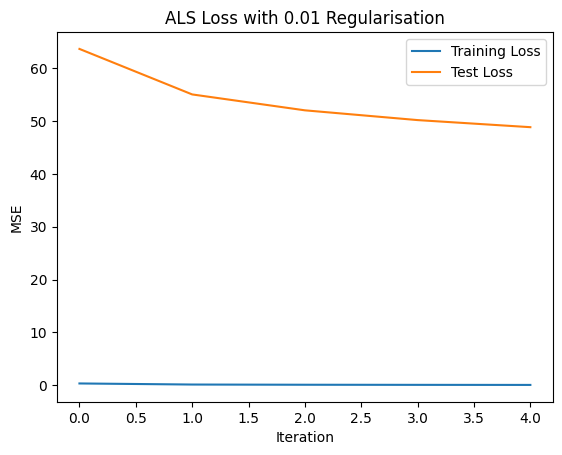

In [56]:
plt.plot(training_losses1, label="Training Loss")
plt.plot(test_losses1, label="Test Loss")
plt.title("ALS Loss with 0.01 Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

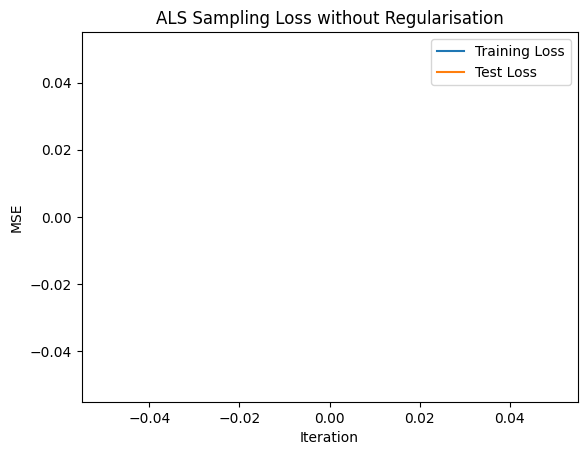

In [46]:
plt.plot(training_losses2, label="Training Loss")
plt.plot(test_losses2, label="Test Loss")
plt.title("ALS Sampling Loss with 0.01 Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

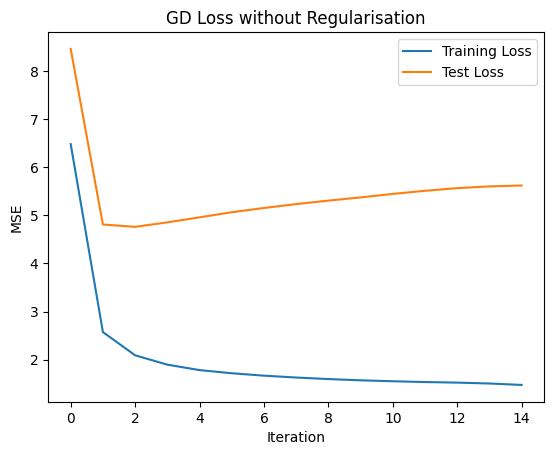

In [47]:
plt.plot(training_losses3, label="Training Loss")
plt.plot(test_losses3, label="Test Loss")
plt.title("GD Loss without Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

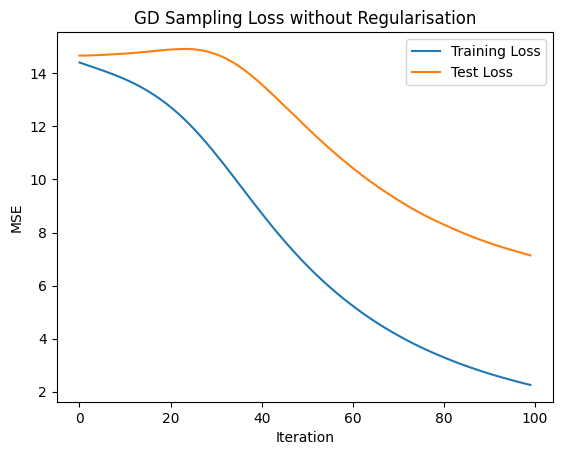

In [48]:
plt.plot(training_losses4, label="Training Loss")
plt.plot(test_losses4, label="Test Loss")
plt.title("GD Sampling Loss without Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

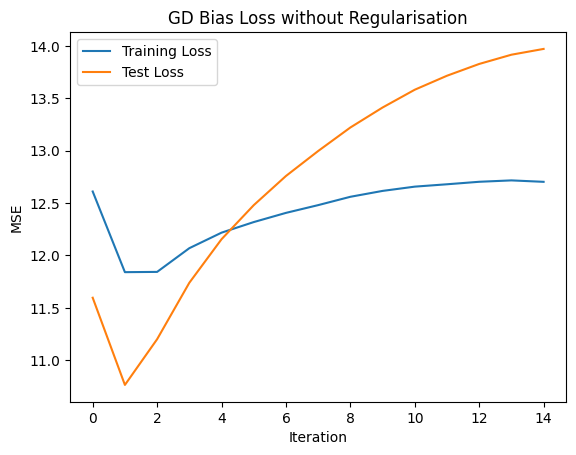

In [49]:
plt.plot(training_losses5, label="Training Loss")
plt.plot(test_losses5, label="Test Loss")
plt.title("GD Bias Loss without Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

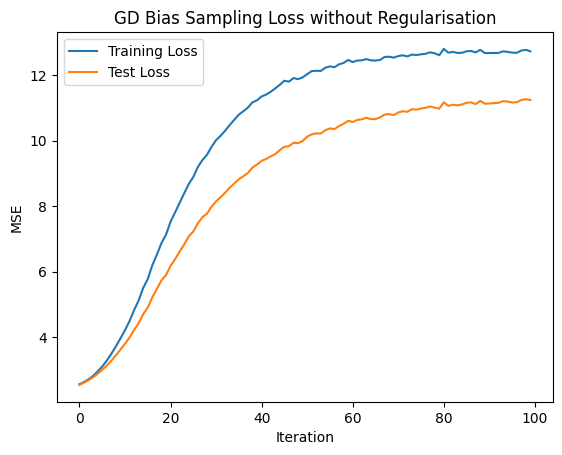

In [50]:
plt.plot(training_losses6, label="Training Loss")
plt.plot(test_losses6, label="Test Loss")
plt.title("GD Bias Sampling Loss without Regularisation")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()

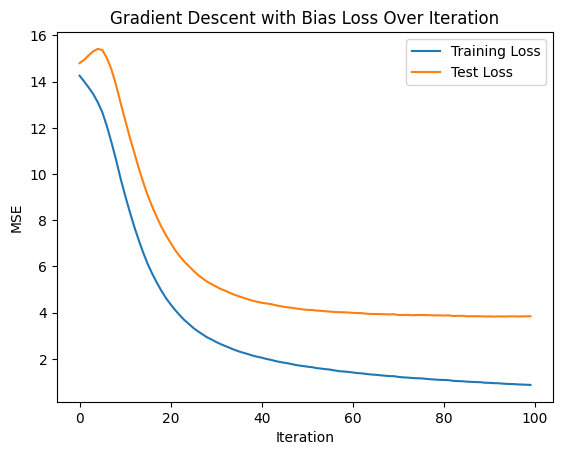

In [40]:
plt.plot(training_losses7, label="Training Loss")
plt.plot(test_losses7, label="Test Loss")
plt.title("Gradient Descent with Bias Loss Over Iteration")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.legend()
plt.show()